In [ ]:
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

import seaborn as sns
import matplotlib.pyplot as plt

import h5py
import json
from pathlib import Path

print("Importing Complete")

Importing Complete


In [ ]:
# Let's take a look at how many tickers were avaliable on yahoo finance and those that were missing.
# We will also need all the SP500 changes to check if our historicals match up with the time they were in the SP500.

avaliable_yf_tickers_filepath = '/p3Ainputs/avaliable_yf_tickers.json'
missing_yf_tickers_filepath = '/p3Ainputs/missing_yf_tickers.json'
sp500_changes_filepath = '/p3Ainputs/S&P500 Consitutents 20061009-20220116.json'

with open(avaliable_yf_tickers_filepath, 'r') as f:
  avaliable_yf_tickers = json.load(f)

with open(missing_yf_tickers_filepath, 'r') as f:
  missing_yf_tickers = json.load(f)

sp500_changes = pd.read_json(sp500_changes_filepath)

print(f'''You have {len(avaliable_yf_tickers)} avaliable tickers and 
          {len(missing_yf_tickers)} missing tickers for a total of 
          {len(avaliable_yf_tickers+missing_yf_tickers)} tickers''')

You have 672 avaliable tickers and 176 missing tickers for a total of 848 tickers


In [ ]:
# Let's also load the historicals we recently downloaded from Yahoo Finance to memory.
# I am loading them from hdf5 files, but the csv loader can be found at the end of the Tutorial 2 notebook.

def load_hdf5_historicals(tickers, filepath):
  '''Load hdf5 historicals to memory.

  Args:
    tickers: list containing each ticker given as a string.
    filepath: string of where the historicals are saved.

  Returns:
    historicals: dict with tickers as keys and OHLC data as values.
                 Each OHLC data is given as a pandas dataframe. 
  '''

  historicals = dict()
  columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  
  for ticker in tickers:
    hdf5_filepath = f'{filepath}/{ticker}.hdf5'
    ticker_file = Path(hdf5_filepath)
    if ticker_file.is_file():
      with h5py.File(hdf5_filepath, 'r') as f:
        group = f['historicals']
        data = group['15Y'][()]
      dataset = pd.DataFrame(data=data, columns=columns)
      dataset['Date'] = pd.to_datetime(dataset['Date'], unit='s')  # Change the float timestamps back to datetimes.
      dataset = dataset.set_index('Date')
      historicals[ticker] = dataset
    else:
      print(f'Error {ticker} ticker is missing')
  print('All Historicals Have Been Loaded')
  return historicals

historicals_filepath = '/p3Ainputs/historicals'
historicals = load_hdf5_historicals(avaliable_yf_tickers, historicals_filepath)

All Historicals Have Been Loaded


In [3]:
# Let's take look at the data.

def collect_all_historical_lengths(historicals):
  '''Collects all common historical lengths.

  Counts the length of data for each ticker in the historicals.
  Same data lengths are tallied up and returned in a list.

  Args:
    historicals: dict with tickers as keys and OHLC data as values.
                 Each OHLC data is given as a pandas dataframe. 
  Returns:
    hist_len_counter: list containing tuple pairs given as
                      [(historical_length, count_of_tickers_with_length), 
                       (historical_length, count_of_tickers_with_length), ...].
  '''

  hist_len_counter = dict()

  for ticker, historical in historicals.items():
    hist_len_counter.setdefault(len(historical), 0)
    hist_len_counter[len(historical)] += 1
  return hist_len_counter

hist_len_counter = collect_all_historical_lengths(historicals)

# Give them a quick sort by most common lengths and highest lenths.
most_common_lens = sorted(hist_len_counter.items(), key=lambda x:x[1], reverse=True)
highest_lens = sorted(hist_len_counter.items(), key=lambda x:x[0], reverse=True)

print(f'Most Common Lens:\n {most_common_lens[:5]}')
print(f'\nHighest Lens:\n {highest_lens[:5]}')

Most Common Lens:
[(3777, 515), (464, 2), (1882, 2), (3677, 2), (1649, 2)]

Highest Lens:
[(3778, 2), (3777, 515), (3776, 1), (3754, 1), (3745, 1)]


In [ ]:
# From above we see that the highest lens is 3778 while the majority of the historicals (515 of them) have 3777 length.
# Additionally in "Highest Lens", we see that past the length of 3777, very few tickers have the same amount of missing data.
# This means that 3777 is the typical length of 15 years of data and we will use this length for reference and comparison.
# However, the 3778 length does stand out, let's take a look at which tickers are causing this.

def find_tickers_that_match_data_length(historicals, data_len):
  '''Finds historical tickers that match specified data length.'''
  tickers = [ticker
             for ticker, historical in historicals.items()
             if data_len == len(historical)]
  return tickers

outlier_len = 3778
outlier_len_tickers = find_tickers_that_match_data_length(historicals, outlier_len)
print(outlier_len_tickers)  # We see that GS and DIA stands out. Since this is a single ticker,
                            # we will simply cut the data point later that is extra from the dataset to keep the data uniform.

standard_len = 3777
standard_len_tickers = find_tickers_that_match_data_length(historicals, standard_len)
print(standard_len_tickers[:5])

['GS', 'DIA']
['A', 'AAL', 'AAP', 'AAPL', 'ABC']


In [ ]:
# Let's make sure all the date ranges at 3777 is the same. From above we see that AAPL has all the data, 
# let's do a quick comparison that tickers of the same length all have the same dates.

def check_for_uniformity_of_dates(historicals, tickers_to_compare, comparison_ticker):
  '''Checks that all dates match if their lengths match.

  Args:
    historicals: dict with tickers as keys and OHLC data as values.
                 Each OHLC data is given as a pandas dataframe. 
    tickers_to_compare: list containing each ticker given as a string.
                        They must all share the same data length.
    comparison_ticker: string of ticker to test dataset uniformity against.

  Returns:
    None
  '''

  for ticker in tickers_to_compare:
    if historicals[ticker].index.equals(historicals[comparison_ticker].index): 
      pass
    else: 
      print(f'{ticker} does not have the same dates as {comparison_ticker}')  # This will only print if the dates do not match with AAPL's dates.
  print('Comparison Completed')
  return

comparison_ticker = 'AAPL'
check_for_uniformity_of_dates(historicals, standard_len_tickers, comparison_ticker)

Comparison Completed


In [ ]:
# Since we have now confirmed that all the tickers that have the length of 3777 also have the same dates, 
# we can now get to work on the missing dates. Let's grab all the tickers that have missing data.

tickers_with_full_data = standard_len_tickers + outlier_len_tickers 
tickers_with_missing_dates = set(historicals) - set(tickers_with_full_data)
print(f'Tickers with missing dates:\n {list(tickers_with_missing_dates)}')

Tickers with missing dates:
 ['HPE', 'ARNC', 'WLTW', 'DNB', 'CA', 'PM', 'DAL', 'DG', 'ROH', 'GM', 'SLR', 'FANG', 'UA', 'EQ', 'HET', 'BUD', 'DOW', 'XL', 'HOT', 'BR', 'CMX', 'NE', 'COTY', 'SEDG', 'CPRI', 'WRK', 'LW', 'NAVI', 'KSU', 'OTIS', 'MRNA', 'ETSY', 'MPC', 'ADT', 'EVHC', 'FRC', 'V', 'LLL', 'CHK', 'ADCT', 'NSM', 'SII', 'DELL', 'VNT', 'CSRA', 'LYB', 'IQV', 'CVG', 'GNRC', 'BEAM', 'SCG', 'DISCK', 'PLL', 'TDC', 'PAYC', 'CDW', 'PX', 'OGN', 'MMI', 'BHF', 'COL', 'NCLH', 'CDAY', 'HII', 'HPC', 'NXPI', 'CBOE', 'SVU', 'HCP', 'JAVA', 'ALTR', 'SYF', 'ALLE', 'NCC', 'H', 'DYN', 'FCPT', 'TWX', 'PYPL', 'TWTR', 'SE', 'SOV', 'CARR', 'KMI', 'ANDV', 'MSCI', 'CHTR', 'XYL', 'ABBV', 'WB', 'FBHS', 'TSLA', 'KEYS', 'AET', 'CBE', 'AWK', 'MDP', 'PSX', 'CFG', 'KHC', 'CBH', 'HCA', 'SNI', 'ANET', 'NWSA', 'SUN', 'KDP', 'LIFE', 'HWM', 'BRL', 'CTLT', 'CTVA', 'FTNT', 'ULTA', 'SAF', 'EPAM', 'FB', 'UST', 'MON', 'ENPH', 'FOX', 'DFS', 'HLT', 'CTX', 'QRVO', 'TEK', 'NOW', 'TRB', 'FTV', 'SHLD', 'TMUS', 'ESRX', 'AVGO', 'CPWR'

In [ ]:
# Compile all the missing dates for each ticker with missing dates and we will compare it 
# to the full date range that the other tickers have.

def compile_tickers_and_missing_dates(historicals, tickers, full_date_range):
  '''Compiles all missing dates for the tickers.

  Args:
    historicals: dict with tickers as keys and OHLC data as values.
                 Each OHLC data is given as a pandas dataframe.
    tickers: list containing each ticker given as a string.
    full_date_range: specified date range to compare each ticker's own data against.
  
  Returns:
    missing_tickers_and_dates: dict with tickers as keys and their missing dates as values.
  '''

  missing_tickers_and_dates = {ticker: full_date_range.difference(historicals[ticker].index) 
                              for ticker in tickers}
  return missing_tickers_and_dates

full_date_range = historicals['AAPL'].index
missing_tickers_and_dates = compile_tickers_and_missing_dates(historicals, tickers_with_missing_dates, full_date_range)

print(missing_tickers_and_dates['TWTR'])  # Let's double check and take a look at one of our tickers and the dates it's missing.

DatetimeIndex(['2007-01-22', '2007-01-23', '2007-01-24', '2007-01-25',
               '2007-01-26', '2007-01-29', '2007-01-30', '2007-01-31',
               '2007-02-01', '2007-02-02',
               ...
               '2013-10-24', '2013-10-25', '2013-10-28', '2013-10-29',
               '2013-10-30', '2013-10-31', '2013-11-01', '2013-11-04',
               '2013-11-05', '2013-11-06'],
              dtype='datetime64[ns]', name='Date', length=1713, freq=None)


In [ ]:
# Since we are only looking for the dates when they are in the SP500.
# We can filter out the missing dates when they were not in the SP500.
# This is because, if the tickers are not in the SP500, we will not consider 
# trading for them. We will need the sp500 changes we loaded in earlier here.

def filter_out_the_dates_not_in_sp500(tickers_and_dates, sp500_changes):
  '''Filters out the dates when the tickers are not in the SP500.
  
  Args:
    tickers_and_dates: dict with tickers as keys and their dates as values.
    sp500_changes: pandas dataframe containing the changes of the SP500 tickers 
                   as a list from 1996 to the present date.
  
  Returns:
    ticker_and_dates_in_sp500: dict with ticker as keys and dates as datetime values.
                               Dates have been filtered to only be when the ticker
                               is in the SP500.
  '''

  tickers_and_dates_in_sp500 = dict()

  for ticker, dates in tickers_and_dates.items():
    # Create a mask that will tell you when the ticker was in the SP500.
    mask = [True if ticker in current_sp500_tickers
            else False
            for current_sp500_tickers in sp500_changes['tickers'].values]
    
    dates_mask = sp500_changes['date'].where(mask, False)
    date_ranges_in_sp500 = _collect_date_ranges_when_in_sp500(dates_mask)  # Collect date ranges because time spent in 
                                                                           # the SP500 is continuous for a range of dates.

    dates = dates.to_series().rename()  # Pandas datetimeIndex needs to be a pandas series and renamed to use pandas series methods on it later.
    tickers_and_dates_in_sp500[ticker] = _collect_each_date_when_in_sp500(dates, date_ranges_in_sp500)
  return tickers_and_dates_in_sp500

def _collect_date_ranges_when_in_sp500(dates_mask): 
  '''Collects all dates when the ticker was in the SP500.

  Args:
    dates_mask: pseudo-bool mask for each date. The False 
                value indicates the ticker was not in the SP500 at that
                date. However, if the ticker was in the SP500 at that date,
                the value will be the date instead of a True value.

  Returns:
    date_ranges_in_sp500: list containing each date range
                          when the ticker was in the SP500.
  '''

  date_ranges_in_sp500 = []
  prev_mask = False  # Keep track of the previous mask to collect the date range at the end.

  for mask in dates_mask:  
    if mask:  # mask will be False until it hits its first date in the SP500.
      if prev_mask == False:
        start_date = mask
      end_date = mask
    else:
      if prev_mask:
        date_ranges_in_sp500.append([start_date, end_date])
    prev_mask = mask
  if prev_mask:  # Ensure that the last date range is added on the last date.
    date_ranges_in_sp500.append([start_date, end_date])
  return date_ranges_in_sp500

def _collect_each_date_when_in_sp500(dates, date_ranges_in_sp500):
  '''Collects all dates for the given SP500 date ranges.

  Args:
    dates: pandas series containing all ticker's dates as a datetime
    date_ranges_in_sp500: list containing each date range
                          when the ticker was in the SP500.
  
  Returns:
    ticker_sp500_dates: pandas series with only the dates for the
                        given date ranges.
  '''
  
  ticker_sp500_dates = None

  for date_range in date_ranges_in_sp500:
    if ticker_sp500_dates is None:
      ticker_sp500_dates = dates.loc[date_range[0]:date_range[1]]
    else:
      ticker_sp500_dates = pd.concat([ticker_sp500_dates, dates.loc[date_range[0]:date_range[1]]])
  return ticker_sp500_dates

def remove_tickers_with_no_missing_dates_while_in_sp500(true_missing_tickers_and_dates):
  '''Removes tickers with no missing dates while in the SP500.'''
  true_missing_tickers_and_dates = {ticker: missing_dates  
                                    for ticker, missing_dates in true_missing_tickers_and_dates.items()
                                    if not missing_dates.empty}
  return true_missing_tickers_and_dates

# Reminder that we are not concerned if the tickers have missing dates outside the times it is in the SP500.
true_missing_tickers_and_dates = filter_out_the_dates_not_in_sp500(missing_tickers_and_dates, sp500_changes)
true_missing_tickers_and_dates = remove_tickers_with_no_missing_dates_while_in_sp500(true_missing_tickers_and_dates)                                                                          

print(f"$SAF's Missing Dates while in the SP500\n{true_missing_tickers_and_dates['SAF'].head()}")  # Let's check with a sample ticker.
print(f"\nBefore cutting tickers that had missing data only when inside SP500, we had {len(missing_tickers_and_dates)} tickers with missing data")
print(f"After cutting tickers that had missing data only when inside SP500, we now have {len(true_missing_tickers_and_dates)} tickers with true missing data")
print(f"Total amount of tickers with missing data is {len(missing_yf_tickers) + len(true_missing_tickers_and_dates)}")

$SAF's Missing Dates while in the SP500
Date
2007-01-22   2007-01-22
2007-01-23   2007-01-23
2007-01-24   2007-01-24
2007-01-25   2007-01-25
2007-01-26   2007-01-26
dtype: datetime64[ns]

Before cutting tickers that had missing data only when inside SP500, we had 153 tickers with missing data
After cutting tickers that had missing data only when inside SP500, we now have 57 tickers with true missing data
Total amount of tickers with missing data is 233


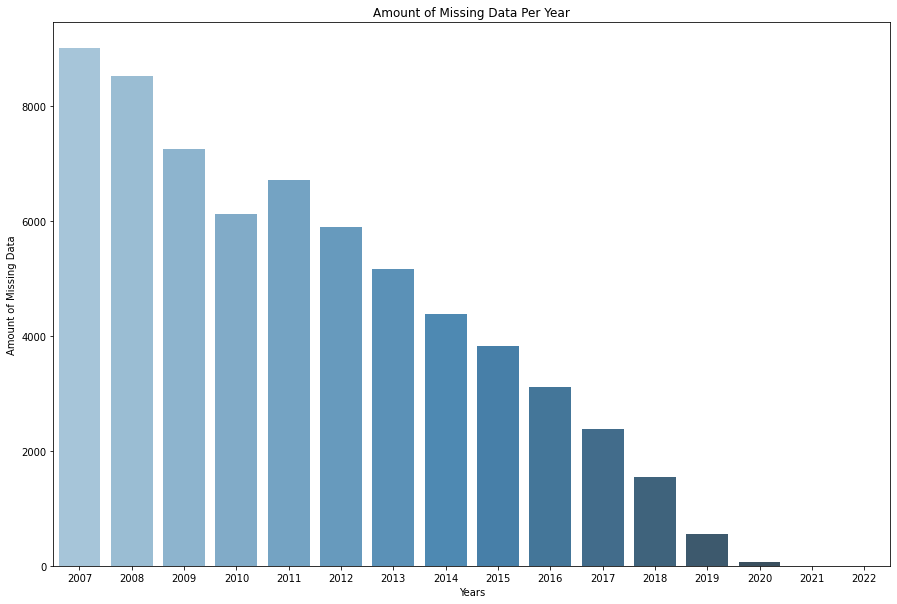

In [ ]:
# Let's make some plots to understand how the missing data might affect our backtests.
# Let's see how the years change the the reliability of the backtest.

def collect_amount_of_missing_data_per_year(missing_tickers_and_dates):
  '''Collects the amount of missing data each year.

  Args:
    missing_tickers_and_dates: dict with ticker as keys and dates as 
                               datetime values.

  Returns:
    missing_occurances: pandas dataframe containing the
                        amount of missing data binned per year
    binned_years: datetimeindex per year used to bin the missing occurances
  '''

  all_dates = None
  for missing_dates in missing_tickers_and_dates.values():
    all_dates = pd.concat([all_dates, missing_dates])
  
  missing_occurances = pd.DataFrame(all_dates, columns=['Dates']).reset_index(drop=True)

  # Create bins for each year to count how much data is missing per year.
  start_date = dt.date(2007, 1, 1)
  end_date = dt.date.today() + relativedelta(years=1)
  binned_years = pd.date_range(start_date, end_date, freq='YS')
  x_axis_labels = binned_years[:-1].strftime('%Y')

  missing_occurances['Years'] = pd.cut(missing_occurances['Dates'],
                                       bins=binned_years,
                                       labels=x_axis_labels)
  return missing_occurances, binned_years
  
missing_occurances, binned_years = collect_amount_of_missing_data_per_year(true_missing_tickers_and_dates)
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(data=missing_occurances,
                   x='Years',
                   palette='Blues_d',
                   ax=ax)
_ = ax.set(title="Amount of Missing Data Per Year", ylabel="Amount of Missing Data")

In [ ]:
# From above we see that the relability of the data greatly increases as the years go by.
# This is most likely because Yahoo Finance tends to remove historicals that went through m&a or went bankrupt.
# This is important as you will want bad companies in the sp500 for your backtest to reduce Survivorship Bias.
# Additionally, this does not include our completely missing_yf_tickers, let's add those to the graph as well.

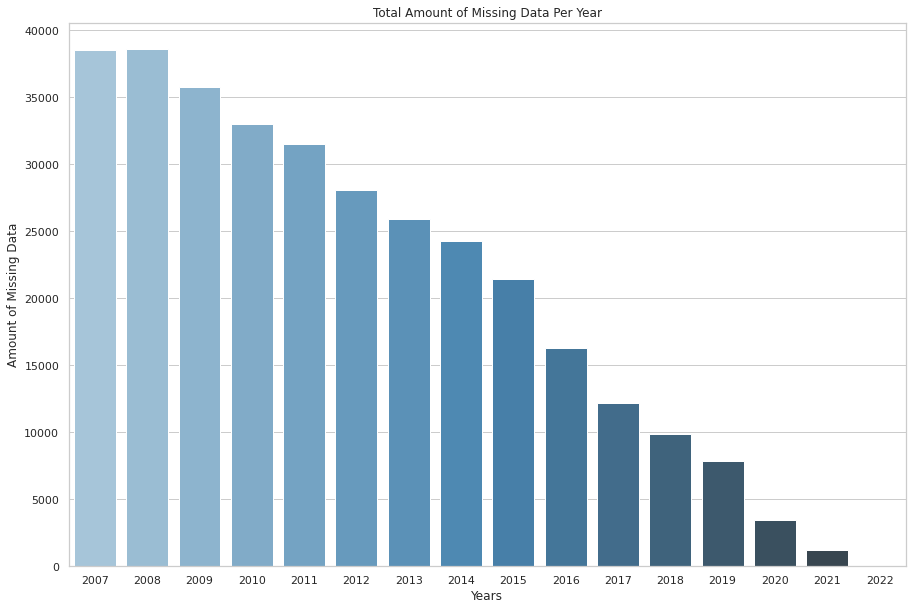

In [ ]:
# We can find all the missing dates for the missing_yf_tickers and tally up all our missing data.

full_missing_tickers_and_dates = compile_tickers_and_missing_dates(missing_yf_tickers, full_date_range, sp500_changes)
full_missing_tickers_and_dates.update(true_missing_tickers_and_dates)
full_missing_data_per_year, _ = collect_amount_of_missing_data_per_year(full_missing_tickers_and_dates)

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(data=full_missing_data_per_year,
                   x='Years',
                   palette='Blues_d',
                   x=ax)
_ = ax.set(title="Total Amount of Missing Data Per Year", ylabel="Amount of Missing Data")

In [ ]:
# Printing out the values we see that there are over 38,000 missing historical dates for the years 2007 and 2008.
# Translating this, there are 252 trading days a year so 38,000/252 we have about 151 out of 500 tickers missing for those years.
# This is cruical because YF tends to delete data on bankrupt and merged companies, we will have to get those companies' data later.

missing_per_year =  full_missing_data_per_year['Dates'].value_counts(bins=binned_years)
print(missing_per_year.sort_index())

(2006-12-31 23:59:59.999999999, 2008-01-01]    38480
(2008-01-01, 2009-01-01]                       38616
(2009-01-01, 2010-01-01]                       35774
(2010-01-01, 2011-01-01]                       32996
(2011-01-01, 2012-01-01]                       31487
(2012-01-01, 2013-01-01]                       28080
(2013-01-01, 2014-01-01]                       25879
(2014-01-01, 2015-01-01]                       24246
(2015-01-01, 2016-01-01]                       21456
(2016-01-01, 2017-01-01]                       16250
(2017-01-01, 2018-01-01]                       12169
(2018-01-01, 2019-01-01]                        9863
(2019-01-01, 2020-01-01]                        7829
(2020-01-01, 2021-01-01]                        3468
(2021-01-01, 2022-01-01]                        1191
(2022-01-01, 2023-01-01]                           0
Name: Dates, dtype: int64


In [ ]:
# Continuing our EDA, let's see the missing data amounts for each ticker.

all_missing_date_lengths = list()
for ticker, missing_dates in full_missing_tickers_and_dates.items():
  all_missing_date_lengths.append([ticker, len(missing_dates)])

all_missing_date_lengths = pd.DataFrame(all_missing_date_lengths, columns=['Ticker','Missing Lengths'])
all_missing_date_lengths = all_missing_date_lengths.sort_values('Missing Lengths', ascending=True, ignore_index=True)

print(all_missing_date_lengths.head(20))
print(all_missing_date_lengths.describe())

   Ticker  Missing Lengths
0     NFX                1
1    EVHC                1
2    ESRX                1
3     TWX                1
4    ANDV                1
5     SNI                1
6     ROH                2
7    CMVT                3
8     CVG               14
9     EOP               15
10   APCC               18
11    HMA               25
12     PD               39
13    CMX               43
14    TSG               49
15      H               53
16  CMCSK               57
17    KMI               87
18   MEDI               91
19    MEL              109
       Missing Lengths
count       233.000000
mean       1406.798283
std        1051.652369
min           1.000000
25%         474.000000
50%        1258.000000
75%        2192.000000
max        3757.000000


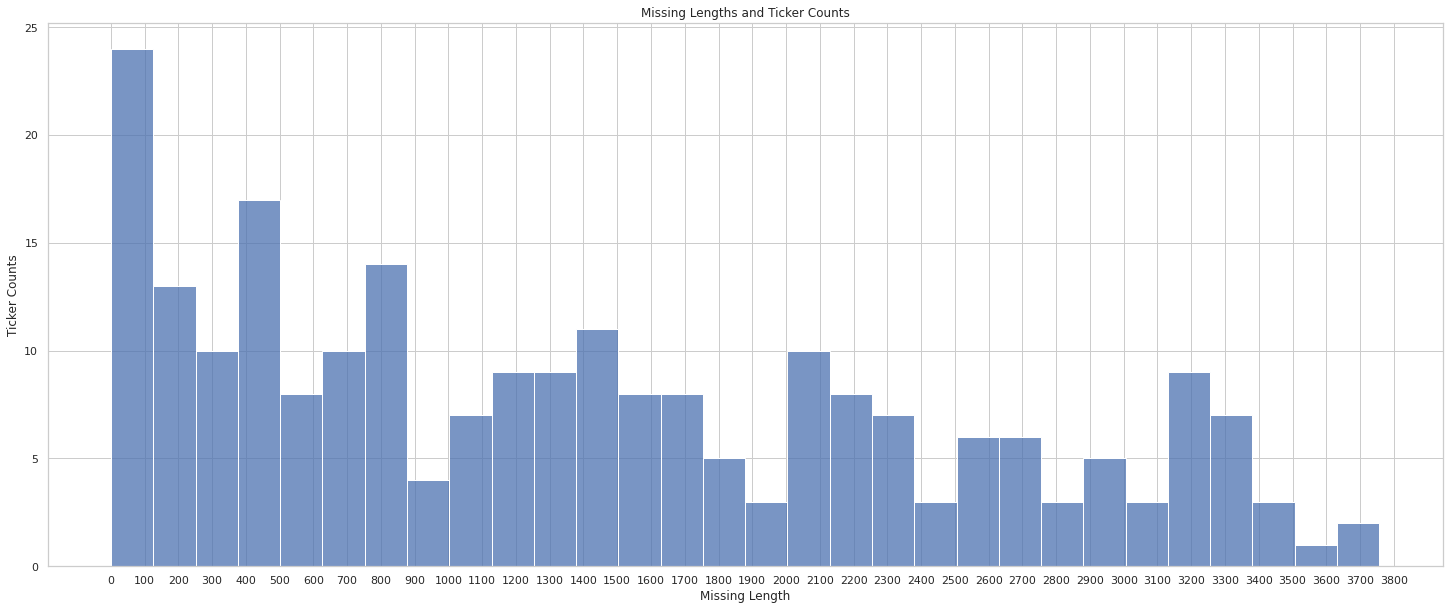

In [ ]:
# Plotting them and seeing the head above we see that there are over 20 tickers with less than 109 dates missing.
# If the data is unavaliable from other databases, we could linearly interpolate them if they are within a tolerance of known data.

fig, ax = plt.subplots(figsize=(25,10))
sns.set_theme(style="whitegrid")          
ax = sns.histplot(x=all_missing_date_lengths['Missing Length'], bins=30, ax=ax)
_ = ax.set(xticks=range(0, 3900, 100), 
          title="Missing Lengths and Ticker Counts",
          ylabel="Ticker Counts")

In [ ]:
# This concludes the end of the this quick EDA.
# Hopefully it gave ways on how you to handle your missing data and the large holes of the Yahoo Finance dataset.
# From here there are a multiple ways to handle the missing data, but I recommend looking for paid for 
# databases to source your data from, and not just Yahoo Finance.
# Additionally here are three common problems among our dataset and even paid sources will share these problems:
  # On the sp500_changes, some tickers are misnamed, for example '$SHLD', which is Sears has the ticker '$SHLDQ'.
  # YF has many missing historicals and even the paid databases are missing information, you will have to do manual research for many.
  # Even historical OHLC data can be wrong.
    # You can create a data pipeline to check for errors or average out your OHLCs from other data sources to approximate the actual result.

In [ ]:
# Finally let's dump our full_missing_tickers_and_dates list, so we can pick them up from a REST API later in Part 3B Tutorial.
# We will have to do some formatting on it to save it as a json.

def format_missing_tickers_and_dates_for_json(full_missing_tickers_and_dates):
  '''Formats missing tickers and dates to save as a json. 

  Changes datetime values to float timestamps in order to save them as a json.

  Args:
    full_missing_tickers_and_dates: dict with ticker as keys and dates as 
                                    datetime values.

  Returns:
    formatted_missing_tickers_and_dates: dict with ticker as keys and dates as 
                                         float timestamp values.
  '''

  formatted_missing_tickers_and_dates = dict()

  for ticker, missing_dates in full_missing_tickers_and_dates.items():
    # Need to convert datetimes to timestamps and a list to save file as a json.
    formatted_missing_tickers_and_dates[ticker] = missing_dates.apply(lambda x: x.timestamp()).values.tolist() 
  return formatted_missing_tickers_and_dates

save_filepath = '/p3Aoutputs/full_missing_tickers_and_dates.json'
formatted_missing_tickers_and_dates = format_missing_tickers_and_dates_for_json(full_missing_tickers_and_dates)

with open(save_filepath, 'w', encoding='utf-8') as f:
  json.dump(formatted_missing_tickers_and_dates, f, ensure_ascii=False, indent=4)

## Reference: Cutting the Extra Date in 'GS' and 'DIA'

In [ ]:
# Let's take a look at GS and DIA.

display(historicals['GS'])
display(historicals['DIA'])

Open        High         Low       Close      Volume
Date                                                                  
2007-01-19         NaN         NaN         NaN         NaN         NaN
2007-01-22  171.830744  173.589023  170.617868  173.361099   4980700.0
2007-01-23  173.239028  173.727431  171.472601  173.092499   6293400.0
2007-01-24  173.800764  179.222121  173.410040  179.165146   6386800.0
2007-01-25  178.945284  179.498809  172.986676  173.442535   7853800.0
...                ...         ...         ...         ...         ...
2022-01-12  403.239990  404.119995  388.559998  390.309998   4158000.0
2022-01-13  394.049988  396.869995  389.750000  390.799988   2497800.0
2022-01-14  382.130005  384.390015  375.000000  380.940002   4682000.0
2022-01-18  360.040009  361.570007  347.230011  354.399994  13123500.0
2022-01-19  358.339996  359.709595  346.390015  347.320007   7277110.0

[3778 rows x 5 columns]

Open        High         Low       Close      Volume
Date                                                                  
2007-01-19         NaN         NaN         NaN         NaN         NaN
2007-01-22   88.966654   88.987923   88.186738   88.449074  10233200.0
2007-01-23   88.420679   88.916990   88.328510   88.860268   6596600.0
2007-01-24   88.987882   89.420379   88.895707   89.384926  10118500.0
2007-01-25   89.356522   89.420335   88.477351   88.604973   8768800.0
...                ...         ...         ...         ...         ...
2022-01-12  363.730011  364.559998  361.670013  362.950012   4493200.0
2022-01-13  364.209991  365.130005  360.450012  361.200012   6418100.0
2022-01-14  358.209991  359.799988  356.399994  359.140015   8573900.0
2022-01-18  355.329987  355.359985  352.619995  353.850006   8166100.0
2022-01-19  354.910004  355.549988  350.220001  350.350006   7355963.0

[3778 rows x 5 columns]

In [ ]:
# We can see that they just have a top Nan row, let's use drop.na() on them in order for them to fit our chosen standard length.

historicals['GS'] = historicals['GS'].dropna()
historicals['DIA'] = historicals['DIA'].dropna()

In [ ]:
# Double check it worked.

print(f"GS Check {full_date_range.difference(historicals['GS'].index}")
print(f"DIA Check {full_date_range.difference(historicals['DIA'].index)}")
display(historicals['GS'])

GS Check DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)
DIA Check DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)


Open        High         Low       Close      Volume
Date                                                                  
2007-01-22  171.830744  173.589023  170.617868  173.361099   4980700.0
2007-01-23  173.239028  173.727431  171.472601  173.092499   6293400.0
2007-01-24  173.800764  179.222121  173.410040  179.165146   6386800.0
2007-01-25  178.945284  179.498809  172.986676  173.442535   7853800.0
2007-01-26  174.655474  174.932237  171.431974  173.792618   7458200.0
...                ...         ...         ...         ...         ...
2022-01-12  403.239990  404.119995  388.559998  390.309998   4158000.0
2022-01-13  394.049988  396.869995  389.750000  390.799988   2497800.0
2022-01-14  382.130005  384.390015  375.000000  380.940002   4682000.0
2022-01-18  360.040009  361.570007  347.230011  354.399994  13123500.0
2022-01-19  358.339996  359.709595  346.390015  347.320007   7277110.0

[3777 rows x 5 columns]

In [ ]:
# Since there was no difference in the dates index, then GS and DIA are now the standard size of our Yahoo Finance Data.
# Because you are reducing the array shape and not extending it you will have to delete your GS and DIA hdf5 files and upload the updated data.